# Classical Electrodynamics - Problem Set 4

## Dimitris Kourtesis - Subatomic Physics Masters

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rcparams import rcparams
mpl.rcParams.update(rcparams)

### Example 4.1 (a):

For a large parallel plate capacitor made of two conducting sheets, with separation $D$, one of which has a small hemispherical boss of radius $\alpha$ on its inner surface $(D\gg \alpha)$, two surface-charge densities were calculated. One at an arbitrary point on the plane and one on the boss. The expression are given by

$$\frac{\sigma_{\text{plate}}}{\epsilon_{0}E_{0}}=\left(1-\frac{\alpha^3}{r^3}\right),\quad r> \alpha$$

and

$$\frac{\sigma_{boss}}{\epsilon_{0}E_{0}}=3\epsilon_{0}E_{0}\cos\theta,\quad 0\leq \theta\leq\pi$$

The two functions are plotted below, in units $\epsilon_{0}E_{0}$.

In [2]:
def sigma_plane(r):
    return 1 - r**(-3)
    
def sigma_boss(theta):
    return 3*np.cos(theta)

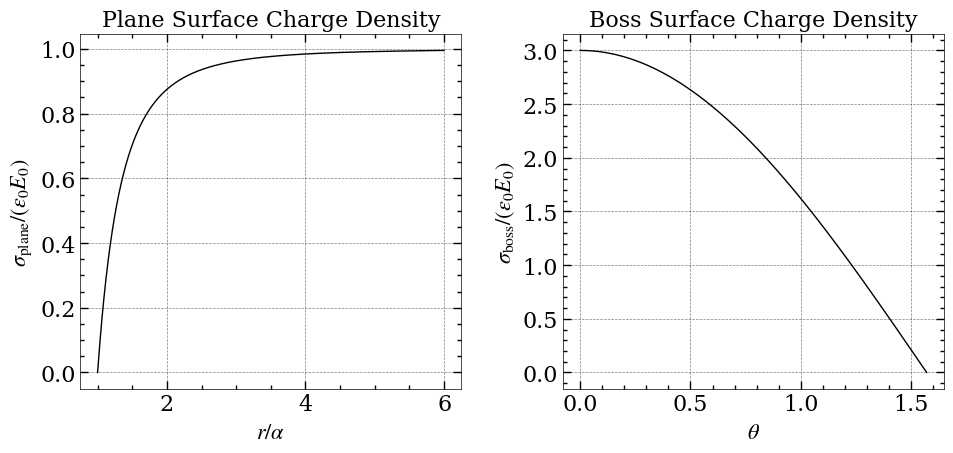

In [3]:
# Domains
r = np.linspace(1, 6.0, 4000) 
theta = np.linspace(0, np.pi/2, 400)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# --- Left plot: plane ---
ax[0].plot(r, sigma_plane(r), color="black")
ax[0].set_xlabel(r"$r/\alpha$")
ax[0].set_ylabel(r"$\sigma_{\mathrm{plane}} / (\epsilon_0 E_0)$")
ax[0].set_title("Plane Surface Charge Density")

# --- Right plot: boss ---
ax[1].plot(theta, sigma_boss(theta), color="black")
ax[1].set_xlabel(r"$\theta$")
ax[1].set_ylabel(r"$\sigma_{\mathrm{boss}} / (\epsilon_0 E_0)$")
ax[1].set_title("Boss Surface Charge Density")

plt.savefig("surface-charges boss and plate.png", dpi=300)
plt.tight_layout()
plt.show()

### Example 4.2 (c):

A line charge with linear charge density $\tau$ is placed parallel to, and a distance $R$ away from, the axis of a conducting cylinder of radius $b$ held at fixed voltage such that the potential vanishes at infinity. The induced surface-charge density was found to be given by:

$$\frac{\sigma}{\frac{\tau}{2\pi b}}=\frac{1-(R/b)^2}{1+(R/b)^2-2(R/b)\cos\phi},\quad 0\leq\phi\leq 2\pi$$

Below, we plot the surface-charge density in units $\frac{\tau}{2\pi b}$ against $\phi$ for $R/b=2,4$.

In [4]:
def sigma(phi, R_b):
    return (1 - R_b**2) / (1 + R_b**2 - 2*R_b*np.cos(phi))

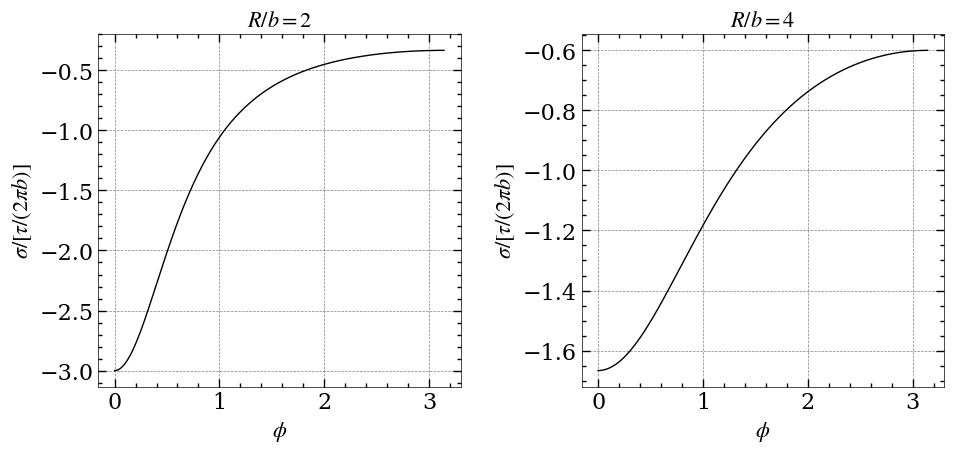

In [5]:
phi = np.linspace(0, np.pi, 4000)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# --- R/b = 2 ---
ax[0].plot(phi, sigma(phi, 2), color="black")
ax[0].set_xlabel(r"$\phi$")
ax[0].set_ylabel(r"$\sigma / [\tau / (2\pi b)]$")
ax[0].set_title(r"$R/b = 2$")

# --- R/b = 4 ---
ax[1].plot(phi, sigma(phi, 4), color="black")
ax[1].set_xlabel(r"$\phi$")
ax[1].set_ylabel(r"$\sigma / [\tau / (2\pi b)]$")
ax[1].set_title(r"$R/b = 4$")

plt.savefig("sigma - R_b.png", dpi=300)
plt.tight_layout()
plt.show()

### Exercise 4.4 (c):

A long hollow conducting cylinder of radius $b$ is divided into equal quarters with alternate segments being held at potential $+V$ and $-V$. The potential was calculated to be given by

$$\Phi(\rho,\phi)=\frac{2V}{\pi}\tan^{-1}\left(\frac{2\rho^{2}b^{2}\sin 2\phi}{b^4-\rho^4}\right)$$

Below, we sketch the field lines and equipotentials.

In [6]:
def Phi(rho, phi, b, V):
    return (2*V/np.pi) * np.arctan( (2 * rho**2 * b**2 * np.sin(2*phi)) / (b**4 - rho**4) )

# Parameters
b = 1.0   # cylinder radius
V = 1.0   # potential magnitude

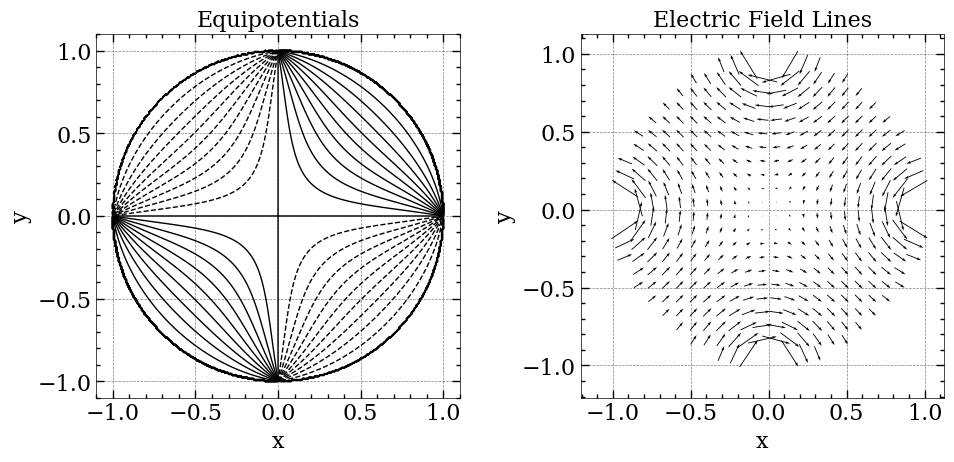

In [7]:
# Grid in Cartesian, then convert to polar
N = 300
x = np.linspace(-1.1*b, 1.1*b, N)
y = np.linspace(-1.1*b, 1.1*b, N)
X, Y = np.meshgrid(x, y)

rho = np.sqrt(X**2 + Y**2)
phi = np.arctan2(Y, X)

# Mask outside the cylinder
mask = rho <= b

# Compute potential only where valid
Phi_vals = np.zeros_like(rho)
Phi_vals[mask] = Phi(rho[mask], phi[mask], b, V)

# Compute electric field: E = -∇Φ
# Use central differences on masked interior only
dX, dY = x[1] - x[0], y[1] - y[0]
Ey, Ex = np.gradient(Phi_vals, dY, dX)   # gradient returns (d/dy, d/dx)
Ex, Ey = -Ex, -Ey                        # E = -∇Φ

# Smoothen the vector field: remove numerical divergences
E_mag = np.sqrt(Ex**2 + Ey**2)
threshold = 10 * np.nanmedian(E_mag)
Ex[E_mag > threshold] = np.nan
Ey[E_mag > threshold] = np.nan
Ex[~mask] = np.nan
Ey[~mask] = np.nan

E_mag = np.sqrt(Ex**2 + Ey**2)

# Compute a cutoff based on upper quantile
cutoff = np.nanpercentile(E_mag, 97.5)  # adjust 99–99.9 depending on how aggressive

# Mask only those extreme spikes
mask_spikes = E_mag > cutoff
Ex[mask_spikes] = np.nan
Ey[mask_spikes] = np.nan

# --- Plot ---
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# 1) Equipotentials
cs = ax[0].contour(X, Y, Phi_vals, levels=20, colors="black", linewidths=1)
ax[0].set_aspect("equal", "box")
ax[0].set_title("Equipotentials")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

# 2) Field Lines (quiver)
# Subsample for clarity
step = 12
ax[1].quiver(X[::step,::step], Y[::step,::step],
             Ex[::step,::step], Ey[::step,::step],
             color="black", pivot="mid", scale=50)
ax[1].set_aspect("equal", "box")
ax[1].set_title("Electric Field Lines")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")

plt.savefig("quiver and equipotentials.png", dpi=300)
plt.tight_layout()
plt.show()